In [11]:
from __future__ import print_function
import keras 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os 
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import seaborn as sys
import pandas as pd 
from keras.models import load_model

In [12]:
num_class = 5
r,c = (224,224)
batch_size = 32

In [13]:
train_data_dir = 'train'
valid_data_dir = 'validation'

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  zoom_range=0.3,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_gen = train_datagen.flow_from_directory(train_data_dir,
                                             target_size=(r,c),
                                             batch_size=batch_size,
                                             class_mode="categorical",
                                             shuffle=True)

valid_gen = valid_datagen.flow_from_directory(valid_data_dir,
                                             target_size=(r,c),
                                             batch_size=batch_size,
                                             class_mode="categorical",
                                             shuffle=True)
num_train = 24256
num_valid = 3006
epochs = 70

Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


In [18]:
m = load_model('face_emotion_image_net.h5')

In [19]:
all_labels = ['Angry','Happy','Neutral','Sad','Surprise']

In [20]:
y_pred = m.predict_generator(valid_gen,num_valid//batch_size+1)

In [21]:
y_pred = np.argmax(y_pred,axis=1)

In [22]:
valid_gen.classes

array([0, 0, 0, ..., 4, 4, 4])

In [23]:
print("Confution matrix")
print(confusion_matrix(valid_gen.classes,y_pred))

Confution matrix
[[  0 491   0   0   0]
 [  0 879   0   0   0]
 [  0 626   0   0   0]
 [  0 594   0   0   0]
 [  0 416   0   0   0]]


In [24]:
print("classification Repot")
print(classification_report(valid_gen.classes,y_pred,target_names=all_labels))
#print(classification_report(valid_gen.classes,y_pred))

classification Repot
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       491
       Happy       0.29      1.00      0.45       879
     Neutral       0.00      0.00      0.00       626
         Sad       0.00      0.00      0.00       594
    Surprise       0.00      0.00      0.00       416

    accuracy                           0.29      3006
   macro avg       0.06      0.20      0.09      3006
weighted avg       0.09      0.29      0.13      3006



C:\Users\Debanik Roy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        auc_score = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc_score(y_test, y_pred, average=average)
    

94/94 [==============================] - 20s 212ms/step


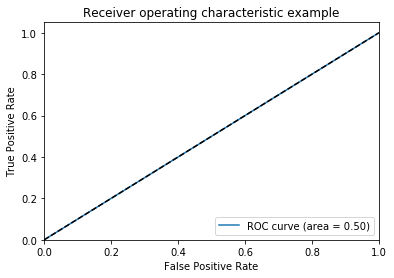

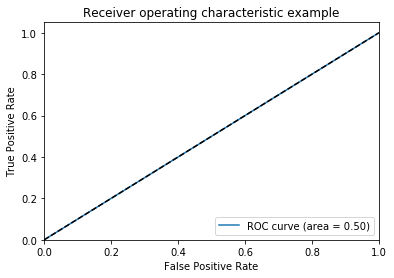

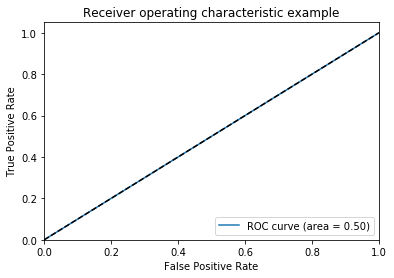

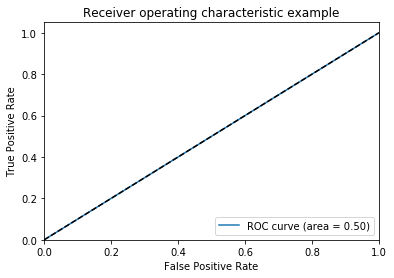

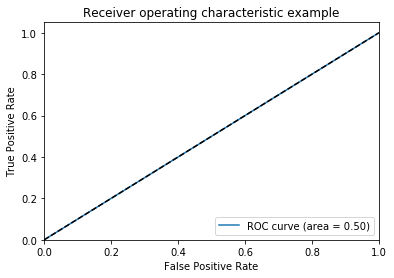

0.5

In [26]:
valid_gen.reset()
y_pred = m.predict_generator(valid_gen,verbose=True)
y_pred = np.argmax(y_pred,axis=1)
multiclass_roc_auc_score(valid_gen.classes,y_pred)


In [27]:
con_mat = tf.math.confusion_matrix(labels=valid_gen.classes, predictions=y_pred).numpy()

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [28]:
print(con_mat)

[[  0 491   0   0   0]
 [  0 879   0   0   0]
 [  0 626   0   0   0]
 [  0 594   0   0   0]
 [  0 416   0   0   0]]


In [29]:
cf_mx_norm = np.around(con_mat.astype("float")/con_mat.sum(axis=1)[:,np.newaxis],decimals=2)

In [30]:
cf_mx_norm_df = pd.DataFrame(cf_mx_norm,index=all_labels,columns=all_labels)
cf_mx_norm_df

,Angry,Happy,Neutral,Sad,Surprise
Angry,0.0,1.0,0.0,0.0,0.0
Happy,0.0,1.0,0.0,0.0,0.0
Neutral,0.0,1.0,0.0,0.0,0.0
Sad,0.0,1.0,0.0,0.0,0.0
Surprise,0.0,1.0,0.0,0.0,0.0


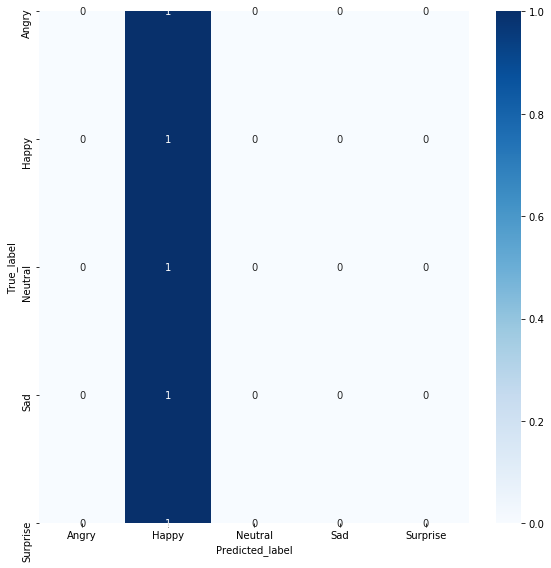

In [31]:
figure = plt.figure(figsize=(8,8))
sys.heatmap(cf_mx_norm_df,annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel("True_label")
plt.xlabel("Predicted_label")
plt.show()